In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/onggkodb/training-c.csv
/kaggle/input/onggkodb/training-c/c17226.png


In [2]:
import torch
import torch.nn as nn
from torch.utils.data.dataset import Dataset
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os

In [3]:
class CustomDatasetFromImages(Dataset):
    def __init__(self, csv_path, img_path, transform = None):
        """
        Args:
            csv_path (string): path to csv file
            img_path (string): path to the folder where images are
            transform: pytorch transforms for transforms and tensor conversion
        """
# Transforms
        self.to_tensor = transforms.ToTensor()
        # Read the csv file
        self.data_info = pd.read_csv(csv_path)
        # Remove every column except 'filename' and 'digit'
        # self.header_list = list(self.data_info.columns)
        # self.rmv_list = []
        # for i in self.header_list:
        #     if i not in ['filename', 'digit']:
        #         self.rmv_list.append(i)
        # self.data_info.drop(
        #     labels = self.rmv_list,
        #     axis = 1,
        #     inplace = True
        # )
        # First column contains the image paths
        # self.image_arr = np.asarray(self.data_info.iloc[:, 0])
        self.image_arr = np.array(self.data_info['filename'])
        # Second column is the labels
        # self.label_arr = np.asarray(self.data_info.iloc[:, 1])
        self.label_arr = np.array(self.data_info['digit'])
        # Calculate len
        self.data_len = len(self.data_info.index)

    def __getitem__(self, index):
        # Get image name from the pandas df
        single_image_name = os.path.join(img_path, self.image_arr[index])
        # Open image
        img_as_img = Image.open(single_image_name)
        img_as_img = img_as_img.resize((28, 28))

        # Transform image to tensor
        img_as_tensor = self.to_tensor(img_as_img)

        # Get label of the image based on the cropped pandas column
        single_image_label = self.label_arr[index]

        return (img_as_tensor, single_image_label)

    def __len__(self):
        return self.data_len

<class 'torch.Tensor'>


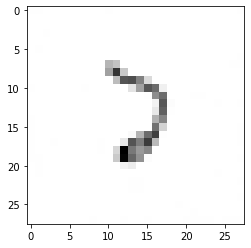

In [79]:
csv_path = '../input/onggkodb/training-c.csv'
img_path = '../input/onggkodb/training-c'

OngkoDB_modified = CustomDatasetFromImages(csv_path, img_path)

show_img = OngkoDB_modified[1][0].numpy().reshape(28, 28)
plt.imshow(show_img, cmap='gray')

print(type(OngkoDB_modified[1][0]))

0.98751503
0.058411848


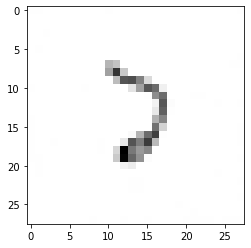

In [5]:
mean_px = show_img.mean().astype(np.float32)
std_px = show_img.std().astype(np.float32)
show_img = (show_img - mean_px)/(std_px)

print(mean_px)
print(std_px)

plt.imshow(show_img, cmap='gray')

In [6]:
print(OngkoDB_modified[0])
print(len(OngkoDB_modified[0]))
print(type(OngkoDB_modified))

(tensor([[[0.9922, 0.9961, 0.9961, 0.9961, 0.9961, 0.9961, 0.9961, 0.9961,
          0.9961, 0.9961, 0.9961, 0.9961, 0.9961, 0.9961, 0.9961, 0.9961,
          0.9961, 0.9961, 0.9961, 0.9961, 0.9961, 1.0000, 0.9961, 0.9961,
          0.9961, 0.9961, 0.9961, 0.9922],
         [0.9961, 1.0000, 0.9961, 0.9961, 0.9961, 0.9961, 1.0000, 0.9961,
          0.9961, 0.9961, 0.9961, 0.9961, 0.9961, 0.9961, 0.9961, 0.9961,
          0.9961, 0.9961, 0.9961, 0.9961, 1.0000, 1.0000, 1.0000, 1.0000,
          0.9961, 0.9961, 1.0000, 0.9961],
         [0.9922, 0.9961, 0.9961, 1.0000, 0.9961, 0.9961, 0.9961, 0.9961,
          0.9961, 0.9961, 0.9961, 0.9961, 0.9961, 0.9961, 1.0000, 1.0000,
          0.9961, 0.9961, 0.9961, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 1.0000, 1.0000],
         [0.9922, 0.9961, 0.9961, 0.9961, 0.9961, 0.9961, 0.9961, 0.9961,
          0.9961, 0.9961, 0.9961, 0.9961, 0.9961, 0.9961, 1.0000, 1.0000,
          1.0000, 0.9961, 0.9961, 0.9961, 1.0000, 1.0000

In [7]:
# Hyperparameters

batch_size = 20 # 100
num_iters = 20000 # 5000
input_dim = 28 * 28 # num_features = 784
num_hidden = 200 # num of hidden nodes # 250
output_dim = 10

learning_rate = 0.01

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
train_size = int(0.8 * len(OngkoDB_modified))
test_size = len(OngkoDB_modified) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(OngkoDB_modified, [train_size, test_size])

num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)   # It's better to shuffle the whole training dataset! 

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [9]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer: 32400 --> 200
        self.linear_1 = nn.Linear(input_size, num_hidden)
        ### Non-linearity in 1st hidden layer
        self.relu_1 = nn.ReLU()

        ### 2nd hidden layer: 200 --> 200
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.relu_2 = nn.ReLU()

        ### 3rd hidden layer: 200 --> 200
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 3rd hidden layer
        self.relu_3 = nn.ReLU()

        ### 4th hidden layer: 200 --> 200
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 4th hidden layer
        self.relu_4 = nn.ReLU()

        ### 5th hidden layer: 200 --> 200
        self.linear_5 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 5th hidden layer
        self.relu_5 = nn.ReLU()

        ### 6th hidden layer: 200 --> 200
        self.linear_6 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 6th hidden layer
        self.relu_6 = nn.ReLU()

        ### Output layer: 200 --> 10
        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)

        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_3(out)

        ### 4th hidden layer
        out  = self.linear_4(out)
        ### Non-linearity in 4th hidden layer
        out = self.relu_4(out)

        ### 5th hidden layer
        out  = self.linear_5(out)
        ### Non-linearity in 5th hidden layer
        out = self.relu_5(out)

        ### 6th hidden layer
        out  = self.linear_6(out)
        ### Non-linearity in 6th hidden layer
        out = self.relu_6(out)
        
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas

In [10]:
'''
INSTANTIATE MODEL CLASS
'''
model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_hidden)
# To enable GPU
model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=784, out_features=200, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=200, out_features=200, bias=True)
  (relu_2): ReLU()
  (linear_3): Linear(in_features=200, out_features=200, bias=True)
  (relu_3): ReLU()
  (linear_4): Linear(in_features=200, out_features=200, bias=True)
  (relu_4): ReLU()
  (linear_5): Linear(in_features=200, out_features=200, bias=True)
  (relu_5): ReLU()
  (linear_6): Linear(in_features=200, out_features=200, bias=True)
  (relu_6): ReLU()
  (linear_out): Linear(in_features=200, out_features=10, bias=True)
)

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [12]:
iter = 0
iteration_loss = []
for epoch in range(num_epochs):
    print('Epoch:', epoch)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28 * 28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28 * 28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Epoch: 0
Iteration: 500. Loss: 2.3020222187042236. Accuracy: 9.465020576131687
Epoch: 1
Iteration: 1000. Loss: 2.299206018447876. Accuracy: 9.91769547325103
Iteration: 1500. Loss: 2.307464838027954. Accuracy: 9.691358024691358
Epoch: 2
Iteration: 2000. Loss: 2.3001577854156494. Accuracy: 9.465020576131687
Iteration: 2500. Loss: 2.3166840076446533. Accuracy: 9.465020576131687
Epoch: 3
Iteration: 3000. Loss: 2.307888984680176. Accuracy: 9.465020576131687
Iteration: 3500. Loss: 2.304009199142456. Accuracy: 10.123456790123457
Epoch: 4
Iteration: 4000. Loss: 2.3014800548553467. Accuracy: 9.465020576131687
Iteration: 4500. Loss: 2.303020477294922. Accuracy: 9.465020576131687
Epoch: 5
Iteration: 5000. Loss: 2.3023271560668945. Accuracy: 9.691358024691358
Iteration: 5500. Loss: 2.3038315773010254. Accuracy: 9.670781893004115
Epoch: 6
Iteration: 6000. Loss: 2.296097755432129. Accuracy: 9.465020576131687
Iteration: 6500. Loss: 2.299224376678467. Accuracy: 9.465020576131687
Epoch: 7
Iteration: 70

[2.3020222187042236, 2.299206018447876, 2.307464838027954, 2.3001577854156494, 2.3166840076446533, 2.307888984680176, 2.304009199142456, 2.3014800548553467, 2.303020477294922, 2.3023271560668945, 2.3038315773010254, 2.296097755432129, 2.299224376678467, 2.3065476417541504, 2.3056912422180176, 2.2958250045776367, 2.306525230407715, 2.293722629547119, 2.30086088180542, 2.313849925994873, 2.302041530609131, 2.312044620513916, 2.305145025253296, 2.303572177886963, 2.305105447769165, 2.3012309074401855, 2.2983832359313965, 2.3059628009796143, 2.2991676330566406, 2.302319049835205, 2.305513381958008, 2.3055529594421387, 2.304084062576294, 2.3014144897460938, 2.304488182067871, 2.3013453483581543, 2.3033759593963623, 2.304530620574951]


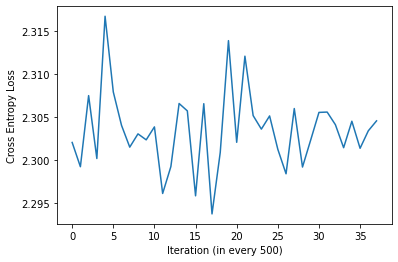

In [13]:
import matplotlib
import matplotlib.pyplot as plt

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

In [14]:
torch.save(model.state_dict(), './exp1.pkl')

In [15]:
model.load_state_dict(torch.load('./exp1.pkl'))

<All keys matched successfully>

In [77]:
class CustomDatasetFromCSV(Dataset):
    def __init__(self, csv_path, transform = None):
        """
        Args:
            csv_path (string): path to csv file
            img_path (string): path to the folder where images are
            transform: pytorch transforms for transforms and tensor conversion
        """
# Transforms
        self.to_tensor = transforms.ToTensor()
        # Read the csv file
        self.data_info = pd.read_csv(csv_path)
        # Remove every column except 'filename' and 'digit'
        # self.header_list = list(self.data_info.columns)
        # self.rmv_list = []
        # for i in self.header_list:
        #     if i not in ['filename', 'digit']:
        #         self.rmv_list.append(i)
        # self.data_info.drop(
        #     labels = self.rmv_list,
        #     axis = 1,
        #     inplace = True
        # )
        # First column contains the image paths
        # self.image_arr = np.asarray(self.data_info.iloc[:, 0])
#         self.image_arr = np.array(self.data_info['filename'])
        # Second column is the labels
        # self.label_arr = np.asarray(self.data_info.iloc[:, 1])
#         self.label_arr = np.array(self.data_info['digit'])
        # Calculate len
        self.data_len = len(self.data_info.index)

    def __getitem__(self, index):
        # Get image name from the pandas df
#         single_image_name = os.path.join(img_path, self.image_arr[index])
        # Open image
#         img_as_img = Image.open(single_image_name)
#         img_as_img = img_as_img.resize((28, 28))
    
        img_as_img = self.data_info.iloc[index , :]
#         img_as_img = list(img_as_img)
        img_as_img = np.array(img_as_img).astype(float)
        norm = np.linalg.norm(img_as_img)
        normal_array = img_as_img / norm
        img_as_img = img_as_img[1 : ].reshape(28, 28)

        # Transform image to tensor
        img_as_tensor = self.to_tensor(img_as_img)

        # Get label of the image based on the cropped pandas column
#         single_image_label = self.label_arr[index]
        single_image_label = self.data_info.iloc[index, 0]

        return (img_as_tensor, single_image_label)

    def __len__(self):
        return self.data_len

In [82]:
csv_path = '../input/verificationdb/verification_test.csv'

verificationdb = CustomDatasetFromCSV(csv_path)

test_loader = torch.utils.data.DataLoader(dataset=verificationdb, 
                                          batch_size=batch_size, 
                                          shuffle=False)

for images, labels in test_loader:
    images = images.view(-1, 28 * 28).to(device)

    # Forward pass only to get logits/output
    outputs = model(images.float())

    # Get predictions from the maximum value
    _, predicted = torch.max(outputs, 1)

    # Total number of labels
    total += labels.size(0)


    # Total correct predictions
    if torch.cuda.is_available():
        correct += (predicted.cpu() == labels.cpu()).sum() 
    else:
        correct += (predicted == labels).sum()

accuracy = 100 * correct.item() / total
print(accuracy)

9.014481094127111
